<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/gaussian_processes_for_regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes for Regression Analysis

## Description

Gaussian processes are flexible probabilistic models that can be used to perform Bayesian regression analysis without having to provide pre-specified functional relationships between the variables.

Probabilistic models, which use Bayesian statistical methods to quantify all aspects of uncertainty relevant to your problem, and provide inferences in simple, interpretable terms using probabilities. A particularly flexible class of probabilistic models uses Bayesian non-parametric methods, which allow models to vary in complexity depending on how much data are available. In doing so, they avoid the over-fitting that is common in machine learning and statistical modeling. 

## Dependencies

In [1]:
!nvidia-smi

Mon Jan  6 02:35:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install arviz

     |████████████████████████████████| 1.4MB 6.7MB/s 
     |████████████████████████████████| 4.1MB 41.2MB/s 
     |████████████████████████████████| 317kB 35.3MB/s 


In [0]:
%matplotlib inline
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_context('notebook')

import warnings
warnings.simplefilter('ignore')

## Case Study #1

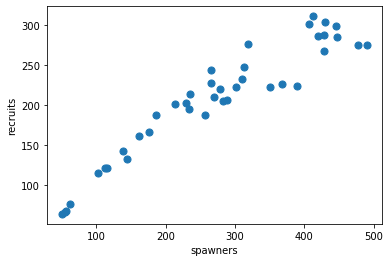

In [4]:
salmon_url = 'https://raw.githubusercontent.com/martin-fabbri/colab-notebooks/master/data/gaussian-processes/salmon_spawning.csv'
salmon_data = pd.read_table(salmon_url, sep=',', index_col=['year'])
salmon_data.plot.scatter(x='spawners', y='recruits', s=50);


### Parametric approaches

Simple linear regression:

$$ y_i = \beta_0 + \beta_1 x_i + \epsilon_i $$

$$ \epsilon_i \sim N(0, \sigma) $$

There are three unknowns, each of which need to be given a prior:

$$\beta_0, \beta_1 \sim \text{Normal}(0, 50)$$

$$\sigma \sim \text{HalfNormal}(50)$$

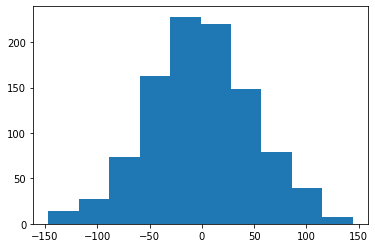

In [5]:
normal_dist = pm.Normal.dist(mu=0, sigma=50)
normal_sample = normal_dist.random(size=1000)
plt.hist(normal_sample);

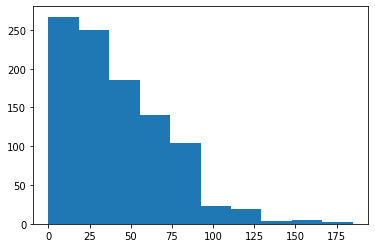

In [6]:
half_distribution = pm.HalfNormal.dist(sigma=50)
half_normal_sample = half_distribution.random(size=1000)
plt.hist(half_normal_sample);

In [0]:
x, y = salmon_data.values.T

In [0]:
# Construct a model in PyMC3
with pm.Model() as linear_salmon_model:
  β = pm.Normal('β', mu=0, sigma=50, shape=2)
  σ = pm.HalfNormal('σ', sigma=50)
  μ = β[0] + β[1] * x
  recruits = pm.Normal('recruits', mu=μ, sigma=σ, observed=y)

In [9]:
# Fit the model using Markov chain Monte Carlo (MCMC)
with linear_salmon_model:
  linear_trace = pm.sample(1000, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:09<00:00, 615.55draws/s]
The acceptance probability does not match the target. It is 0.7044531468437, but should be close to 0.8. Try to increase the number of tuning steps.


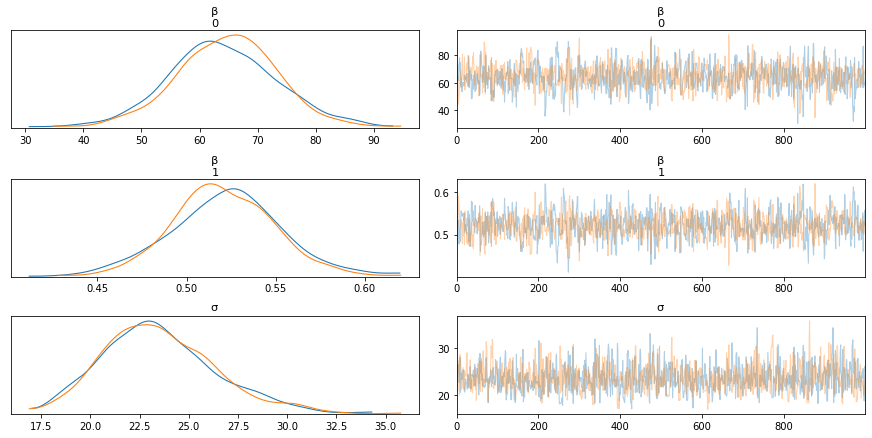

In [10]:
# Examine the posterior distributions of the unknown parameters
az.plot_trace(linear_trace);

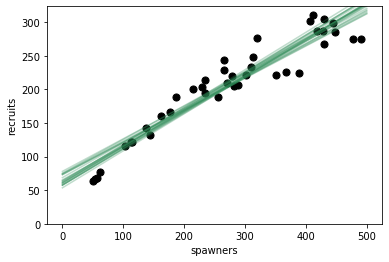

In [11]:
# Draw posterior samples of the regression line
X_pred = np.linspace(0, 500, 100)
ax = salmon_data.plot.scatter(x='spawners',y='recruits',c='k',s=50)
ax.set_ylim(0,None)
for b0,b1 in linear_trace['β'][:20]:
  ax.plot(X_pred, b0 + b1*X_pred, alpha=0.3, color='seagreen');

## Quadratic Model

It appears the linear model is a poor fit to the data. Let's make a polynomical (quadratic) model by adding a parameter for $x^2$.

β, σ, μ

In [0]:
with pm.Model() as quad_salmon_model:
  β = pm.Normal('β', mu=0, sigma=50, shape=3)
  σ = pm.HalfNormal('σ', sigma=50)
  μ = β[0] + β[1] * x + β[2] * x**2
  recruits = pm.Normal('recruits', mu=μ, sigma=σ, observed=y)

In [13]:
with quad_salmon_model:
  quad_trace = pm.sample(1000, tune=2000, cores=2, random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:41<00:00, 143.80draws/s]
The number of effective samples is smaller than 25% for some parameters.


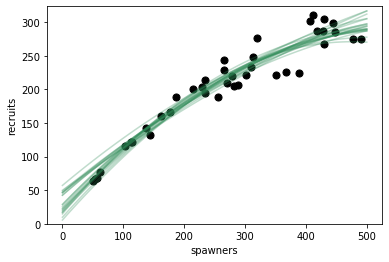

In [14]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for b0,b1,b2 in quad_trace['β'][:20]:
   ax.plot(X_pred, b0 + b1*X_pred + b2*X_pred**2, alpha=0.3, color='seagreen');

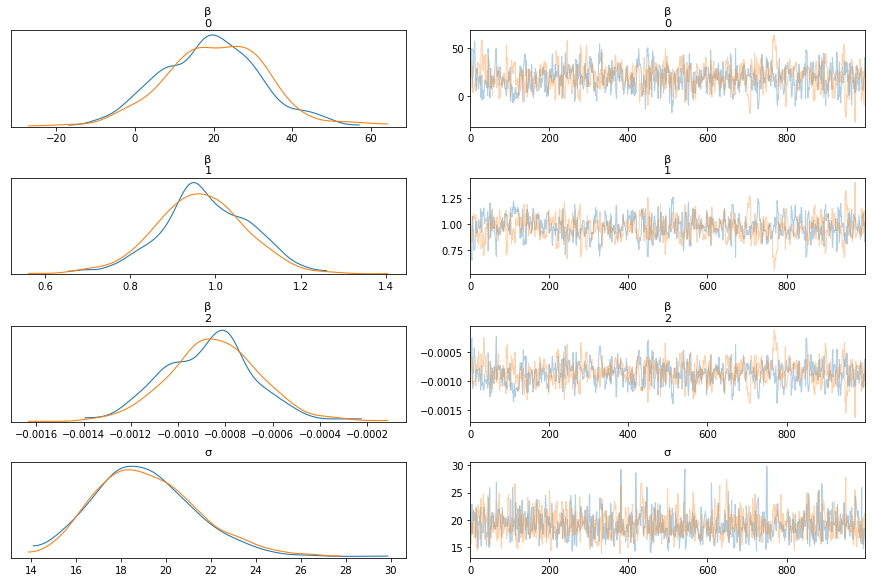

In [15]:
# Examine the posterior distributions of the unknown parameters
az.plot_trace(quad_trace);

## Gaussian Process

ρ, η, M, K, σ 

### Explore non parametric functions



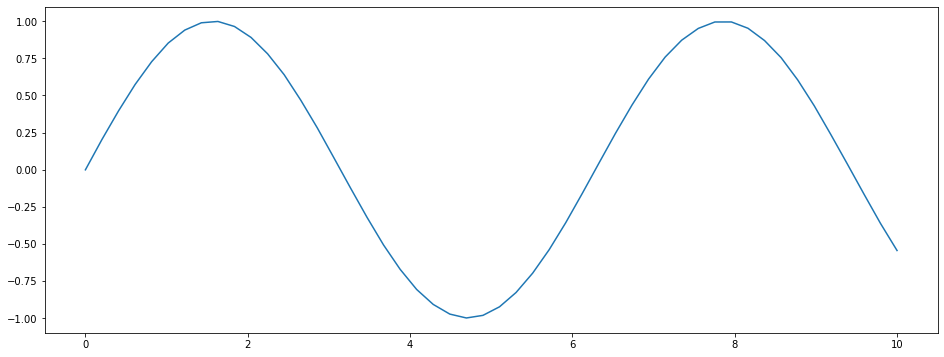

In [16]:
n = 50
x = np.linspace(0, 10, n)
# Defin the gaussian with mu=sin(x) and neglible covariance matrix
norm = stats.multivariate_normal(mean=np.sin(x), cov=np.eye(n) * 1e-6)
plt.figure(figsize=(16,6))

# taking a sample from the distribution and plotting it
plt.plot(x, norm.rvs());

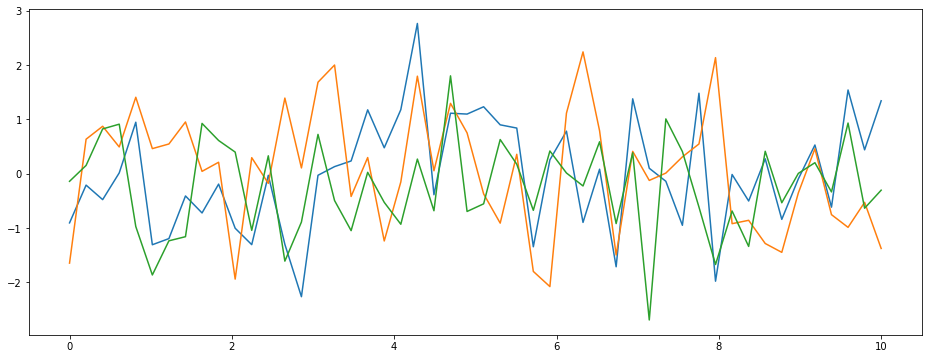

In [17]:
# define the gaussian with mu=0 and convariance matrix without correlation
# but with uncertainty
norm = stats.multivariate_normal(mean=np.zeros(n), cov=np.eye(n))
plt.figure(figsize=(16,6))
[plt.plot(x, norm.rvs()) for _ in range(3)];

Squared exponential kernel

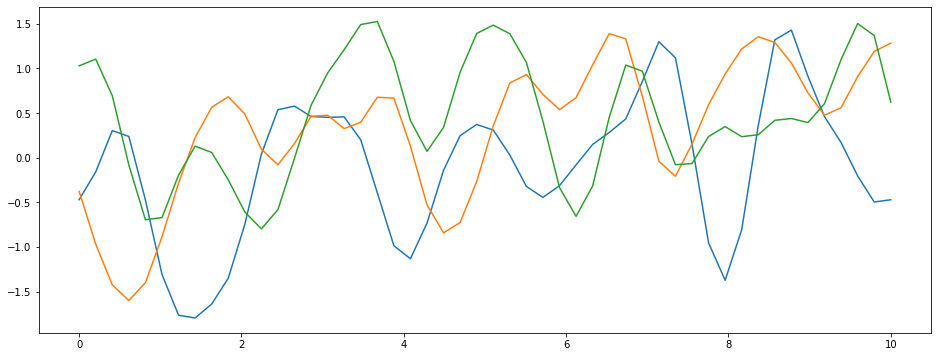

In [18]:
def kernel(m1, m2, l=1):
  return np.exp(-1 / (2 * l**2) * (m1[:, None] - m2)**2)

n = 50
x = np.linspace(0, 10, n)
cov = kernel(x, x, 0.44)

norm = stats.multivariate_normal(mean=np.zeros(n), cov=cov)
plt.figure(figsize=(16,6))
[plt.plot(x, norm.rvs()) for _ in range(3)];

Gaussian Processes

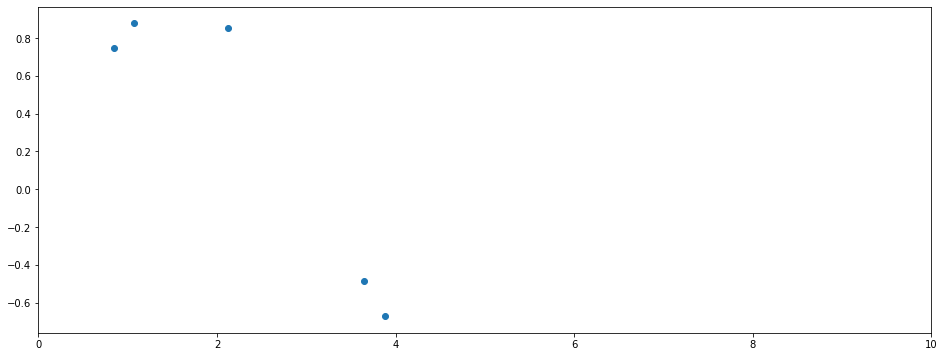

In [19]:
np.random.seed(512)
# true function
f = lambda x: np.sin(x)

# known domain of true function f
x = np.random.uniform(0, 10, 5)
plt.figure(figsize=(16,6))
plt.scatter(x, f(x))
plt.xlim(0,10);

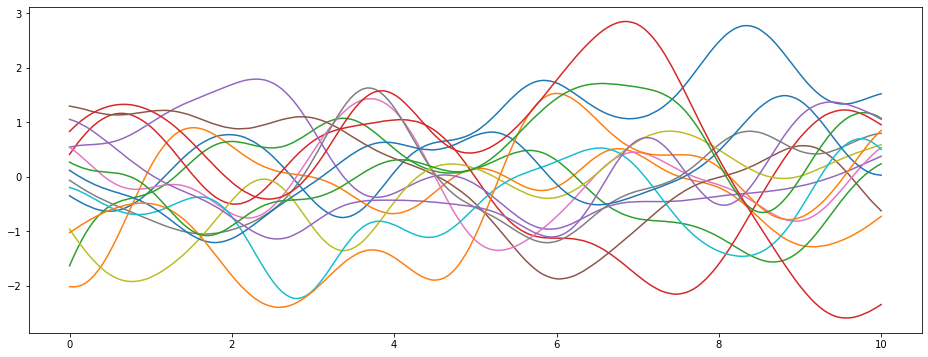

In [20]:
n=200
# domain of f* we want to infer
x_s = np.linspace(0, 10, n)
K_ss = kernel(x_s, x_s, l=0.8)

# is square root of matrix (standard deviation)
L_ss = np.linalg.cholesky(K_ss + 1e-6 * np.eye(n))

# N~(0, 1) * L
f_prior = np.dot(L_ss, np.random.normal(size=(n,15)))
plt.figure(figsize=(16,6))
plt.plot(x_s, f_prior);

In [0]:
with pm.Model() as gp_salmon_model:
  # lenghtscale
  ρ = pm.HalfCauchy('ρ', 5) 
  η = pm.HalfCauchy('η', 5)
  M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits / salmon_data.spawners).mean())
  K = (η**2) * pm.gp.cov.ExpQuad(1, ρ)
  σ = pm.HalfNormal('σ', 50)
  recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
  recruit_gp.marginal_likelihood('recruits', X=salmon_data.spawners.values.reshape(-1,1),
                                 y=salmon_data.recruits.values, noise=σ)


In [22]:
with gp_salmon_model:
  gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]
Sampling 2 chains: 100%|██████████| 6000/6000 [01:08<00:00, 91.91draws/s] 
The number of effective samples is smaller than 25% for some parameters.


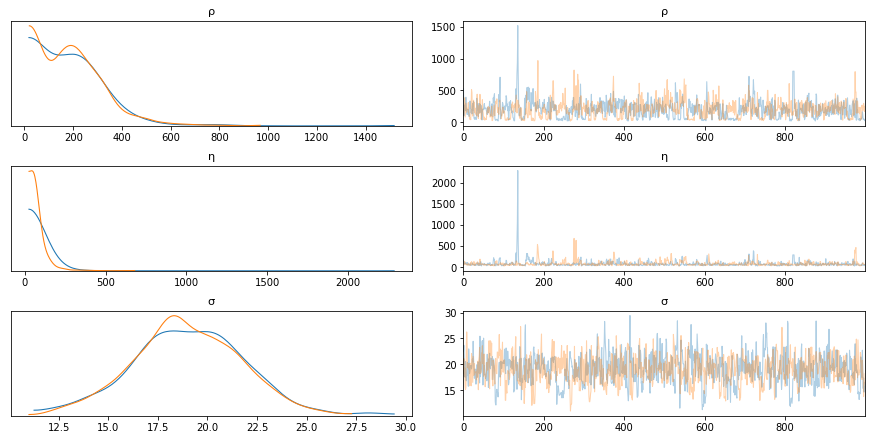

In [24]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

## Case Study #2: Coal Mining Disasters in the UK

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period.

Next we will build a model for this series and attempt to estimate changes in the underlying risk of disasters.


In [4]:
# Time series of recorded coal mining disasters in the UK from 1851 to 1962
disasters_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                        3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                        2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                        1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                        0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                        3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
year = np.arange(1851, 1962)
year_ind = (year - year.min()).reshape(-1,1)
year_ind.shape

(111, 1)

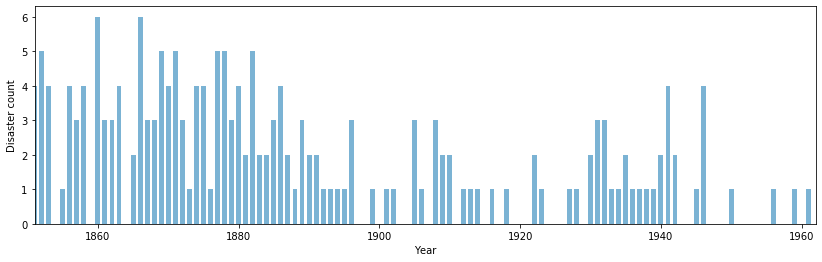

In [5]:
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(year, disasters_data, color='#348ABD', alpha=0.65, width=0.7)
ax.set_xlim(year[0], year[-1] + 1)
ax.set_ylabel('Disaster count')
ax.set_xlabel('Year');

In [0]:
with pm.Model() as disaster_model:
  # hyperpriors on covariance function parameters
  ρ = pm.Exponential('ρ', 1)
  η = pm.Exponential('η', 1)

  # covariance function 
  K = η**2 * pm.gp.cov.ExpQuad(1, ρ)

  # latent GP
  gp = pm.gp.Latent(cov_func=K)

In [0]:
with disaster_model:
  f = gp.prior('f', X=year_ind)

In [0]:
with disaster_model:
  λ = pm.Deterministic('λ', pm.math.exp(f))
  confirmation = pm.Poisson('confirmation', λ, observed=disasters_data)

In [12]:
with disaster_model:
  trace = pm.sample(1000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [f_rotated_, η, ρ]
100%|██████████| 2000/2000 [04:10<00:00,  7.91it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2fb680f60>,
      dtype=object)

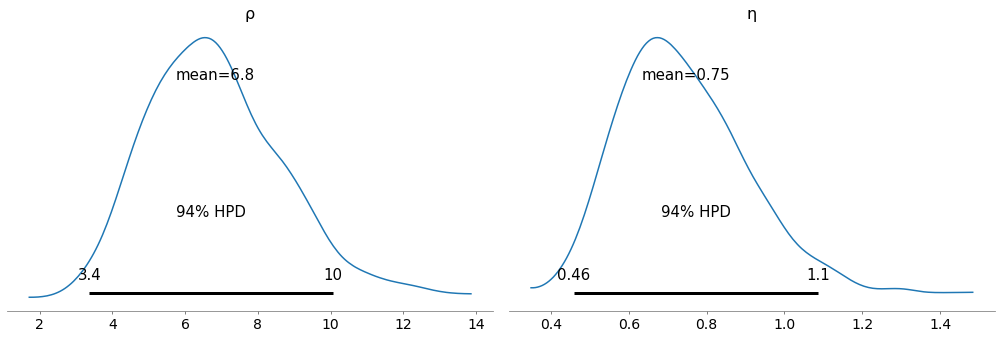

In [13]:
az.plot_posterior(trace, var_names=['ρ', 'η'])

In [0]:
years = (year - year.min())

In [15]:
with disaster_model:
  y_pred = pm.sample_posterior_predictive(trace, vars=[f], samples=1000)

100%|██████████| 1000/1000 [00:03<00:00, 309.01it/s]


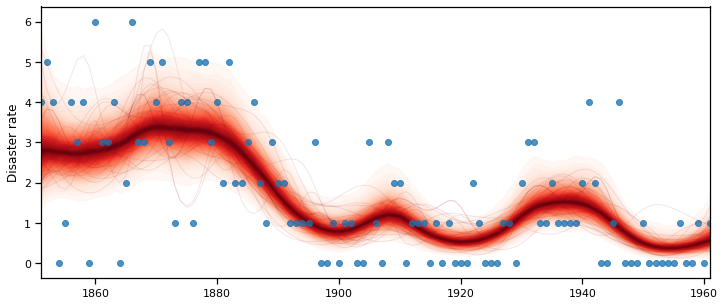

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))

pm.gp.util.plot_gp_dist(ax, np.exp(y_pred['f']), year[:, None])
sns.regplot(year, disasters_data, fit_reg=False, ax=ax)
ax.set_xlim(year.min(), year.max())
ax.set_ylabel('Disaster rate');